In [13]:
import numpy as np
import cv2
import time
import os
from tqdm import tqdm
import random

from IPython.core.display import display,Image

# Enable inline plotting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Make the graphs a bit prettier, and bigger
sns.set(font_scale = 1.5)
sns.set_style("ticks")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams['figure.figsize'] = (8, 6)
IMAGES_DIRECTORY = 'image/'

C:\Users\swats\AppData\Local\Temp\ipykernel_16696\2898247521.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display,Image


In [14]:
# This helper function visualizes the loaded image    
def show_img(image):
    tmp_img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)
    plt.axis('off')

## Harris Corner Detector
The Harris Corner Detector is a combined edge and corner detector.



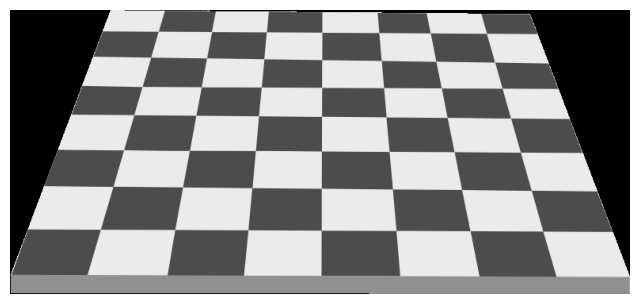

In [15]:
### Display the image before applying Harris Corner Detector
filename = 'image/chessboard.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
show_img(gray)

OpenCV has a built-in implementation of Harris corner detector, in the function `cv.cornerHarris()`. Its arguments are:

- img - Input image. It should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection (set = 2 in the code).
- ksize - Aperture parameter of the Sobel derivative used (set = 3 in the code).
- k - Harris detector free parameter in the equation (set = 0,04 in the code).


In [16]:
gray = np.float32(gray)
result = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)

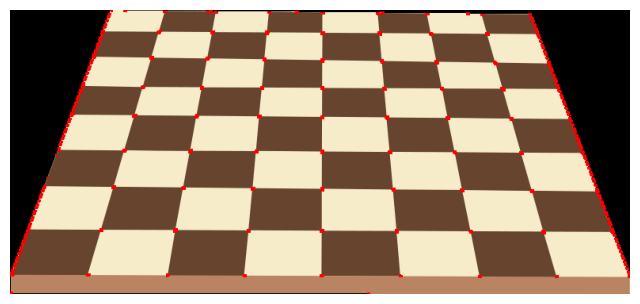

In [17]:
# Result is dilated for marking the corners
result = cv2.dilate(result,None)

# Threshold for an optimal value, it may vary depending on the image.
img[result>0.01*result.max()]=[0,0,255]
show_img(img)

## Comparing Naive For-Loop Convolution with Numpy Convolution

In [18]:
def construct_fx_fy_gradient_kernel():
    # output the fx and fy filters
    fx_kernel=np.array([[1,-1], [1,-1]]) 
    fy_kernel=np.array([[1,1], [-1,-1]])
    return fx_kernel, fy_kernel

def forloop_convolution(filter_area, kernel):
    kernel_height,kernel_width=kernel.shape
    
    average_value=0
    for krow in range(kernel_height):
        for kcol in range(kernel_width):
            average_value += filter_area[krow][kcol] * kernel[krow][kcol]
    if average_value < 0:
        return 0
    if average_value > 255:
        return 255
    return int(average_value)

def forloop_image_gradient_filter(image):
    newimage_fx = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    newimage_fy = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    fx_kernel, fy_kernel = construct_fx_fy_gradient_kernel()
    
    for row in range(1, image.shape[0]):
        for column in range(1, image.shape[1]):
            # Get the area to be filtered with range indexing.
            #print('row', row, 'col', column)
            filter_area = image[(row - 1):(row+1), (column - 1):(column+1)]
            #print('filter_area.shape=', filter_area.shape)
            newimage_fx[row-1][column-1] = forloop_convolution(filter_area, fx_kernel)
            newimage_fy[row-1][column-1] = forloop_convolution(filter_area, fy_kernel)

    
    return newimage_fx, newimage_fy

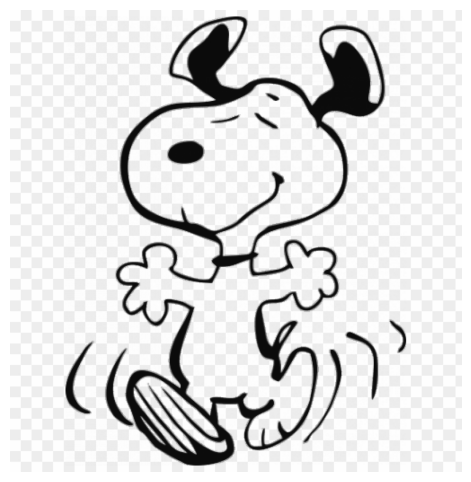

In [19]:
image_name ='snoopy.png'
image = cv2.imread(IMAGES_DIRECTORY + image_name, 0)
show_img(image)

### Computing the total time for the convolution operation using for-loop:

Time used for `forloop` implementation is 4.818206787109375


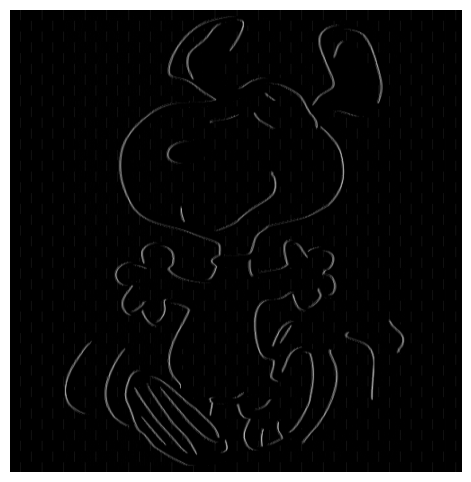

In [20]:
start = time.time()
res_fx, res_fy = forloop_image_gradient_filter(image)
loop_time = time.time() - start
print("Time used for `forloop` implementation is {}".format(loop_time))
show_img(res_fx)

Implementing convolution with Numpy:

In [21]:
def np_convolution(area,kernel):
    rslt = int(np.sum((area * kernel)))
    if rslt < 0:
        return 0
    if rslt > 255:
        return 255
    return rslt


In [22]:
def np_image_gradient_filter(image):
    newimage_fx = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    newimage_fy = np.zeros((image.shape[0]-1, image.shape[1]-1), dtype=np.uint8)
    fx_kernel, fy_kernel = construct_fx_fy_gradient_kernel()
    
    for row in range(1, image.shape[0]):
        for column in range(1, image.shape[1]):
            filter_area = image[(row - 1):(row+1), (column - 1):(column+1)]
            newimage_fx[row-1][column-1] = np_convolution(filter_area,fx_kernel)
            newimage_fy[row-1][column-1] = np_convolution(filter_area,fy_kernel)
    return newimage_fx, newimage_fy

### Computing the total time for the convolution operation using Numpy:

Time used for `Numpy` implementation is 7.7431640625


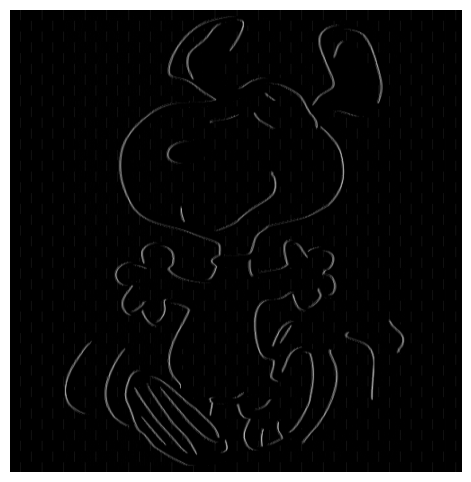

In [23]:
start = time.time()
res_fx, res_fy = np_image_gradient_filter(image)
np_time = time.time() - start

print("Time used for `Numpy` implementation is {}".format(np_time))
# This is odd because it is expected for numpy to be noticeably faster than the for loop implementation


show_img(res_fx) # 

In [24]:
fast_factor = 0.0
fast_factor = loop_time / np_time


print('Numpy is %r times faster than for loop implementation.'%(fast_factor))
# Again, this is odd because it is expected for numpy to be noticeably faster than the for loop implementation


Numpy is 0.6222529638037584 times faster than for loop implementation.


## MNIST Classification via Feature Extraction

In [29]:
from keras.datasets import mnist
(train_X, train_y), _ = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


For this classification problem/task, we only consider binary classification. Hence we only extract data labelled -1 or 1. 

The function filter_images_for_binary_classification prepares the dataset by selecting only data labelled as -1 or 1. It also extracts the edge features using previously used image filters.

In [30]:
def filter_images_for_binary_classification(X, y, filtered_numbers=[0, 7]):
    newX, newy=[], []
    for xi, yi in zip(X,y):
        if yi==filtered_numbers[0]:
            fx, fy = np_image_gradient_filter(xi)
            newX.append(np.concatenate((fx.flatten(), fy.flatten()), axis=0))
            newy.append(-1)
        if yi==filtered_numbers[1]:
            fx, fy = np_image_gradient_filter(xi)
            newX.append(np.concatenate((fx.flatten(), fy.flatten()), axis=0))
            newy.append(1)
    return np.asarray(newX), np.asarray(newy)

The below code normalizes the features X to be between 0 and 1 (a common preprocessing step). Also, this will take a few minutes to run.

In [31]:
X, y=filter_images_for_binary_classification(train_X, train_y)
minx,maxx=X.min(), X.max()
X=np.asarray([(xi-minx)/(maxx-minx) for xi in X])


The next step is to create a logistic regression model and fit it using the existing data:

In [32]:
def sigmoid(x):
    # Numerically-stable sigmoid function
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)

In [33]:
def logistic_regression_update_single(wt,xt,yt):
    result = None
    wtxt = np.dot(wt,xt)
    #print(((-1)*yt)*wtxt)
    return wt + ( (sigmoid( ( (-1)*yt ) * wtxt) ) * (yt) * (xt) )
    #sigmoid((-1*yt)*)
    return result

In [34]:
def logistic_regression_training(X, Y):
    w = np.zeros(len(X[0]))
    data_size = len(X)
    epochs = 2000

    for t in range(epochs):
        rand_idx = np.random.choice(data_size)
        xn, yn = X[rand_idx], Y[rand_idx]
        w = logistic_regression_update_single(w,xn,yn)
    return w

In [35]:
w = logistic_regression_training(X,y)

In [36]:
def predict(w, X):
    y_pred=[]
    for xi in X:
        if np.dot(w.T, xi) > 0:
            y_pred.append(1)
        else:
            y_pred.append(-1)
        
    return y_pred

In [37]:
y_pred=predict(w,X)

### How good is the prediction?
Accuracy defined as: 

$$Accuracy=\frac{\mathbf{1}[y_i=y_{pred,i}]}{n}$$



In [38]:
def compute_accuracy(y_true, y_pred):
    numerator = 0
    for i in range(len(y_pred)):
        if y_true[i] == y_pred[i]:
            numerator += 1
    return numerator / len(y_pred)
    
print('Accuracy=', compute_accuracy(y, y_pred))

Accuracy= 0.9931079750574335


In [42]:
len(y)

12188

So, after training by updating the weights based on 2000 random sampled data points, the model achieves 99.31% accuracy when predicting for all 12188 data points.